# Covariance, Correlation & Diversification

## Covariance

You already know that **variance** measures the spread of a *single* random variable.

**Covariance** $Cov(X, Y)$ measures how **two** variables move together:

$$Cov(X,Y) = E[(X - E[X])(Y - E[Y])]$$

## Intuition

*   **Positive:** When $X$ is above its mean, $Y$ tends to be **above** its mean.
*   **Negative:** When $X$ is above its mean, $Y$ tends to be **below** its mean.
*   **Near Zero:** No linear relationship.

**Note on Units:** The units of covariance are the product of the units of $X$ and $Y$. This quantitative value is hard to interpret or compare across different pairs of assets.

## Exercise 1
Compute covarianvce of AAPL and TLT.

In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ["AAPL", "TLT"] # Our assets to be compared
start_date = "2020-01-01"
end_date = "2023-11-30"

# Download prices
prices_df = pd.DataFrame()
for t in tickers:
    data_t = yf.download(t, start=start_date, end=end_date, progress=False, auto_adjust=False)
    prices_df[t] = data_t["Close"]

# Compute log returns
log_ret_df = np.log(prices_df / prices_df.shift(1)).dropna()

In [6]:
assetA, assetB = "AAPL", "TLT"
rA = log_ret_df[assetA]
rB = log_ret_df[assetB]

cov_AB = np.cov(rA, rB, ddof=1)[0, 1]   # numpy covariance matrix
print("Sample covariance:", cov_AB)

# Compare to manual formula
meanA, meanB = rA.mean(), rB.mean()
cov_manual = ((rA - meanA) * (rB - meanB)).sum() / (len(rA) - 1)
print("Manual covariance:", cov_manual)

Sample covariance: -3.0188481086097205e-05
Manual covariance: -3.0188481086097198e-05


### Questions

1. _Is the covariance positive or negative?_

It is negative, which implies that the assets move in opposite directions.

2. _Does that match your intuition about how those assets move?_

Yes, TLT is a bond, so it moves inversely to the yield curve. AAPL is a stock, so it moves with the market.

# Correlation & Matrix / Heatmap

## Correlation

**Correlation** normalizes covariance to a dimensionless number between -1 and 1:

$$\rho_{XY} = \frac{Cov(X, Y)}{\sigma_X \sigma_Y}$$

## Interpretation

*   $\rho \approx 1$: Almost perfect co-movement.
*   $\rho \approx -1$: Move in opposite directions.
*   $\rho \approx 0$: Little or no linear relation.

**Correlation Matrix:** For many assets, this is a table showing all pairwise correlations.

## Exercise 2
Plot correlation matrix of AAPL and TLT.

          AAPL       TLT
AAPL  1.000000 -0.119749
TLT  -0.119749  1.000000


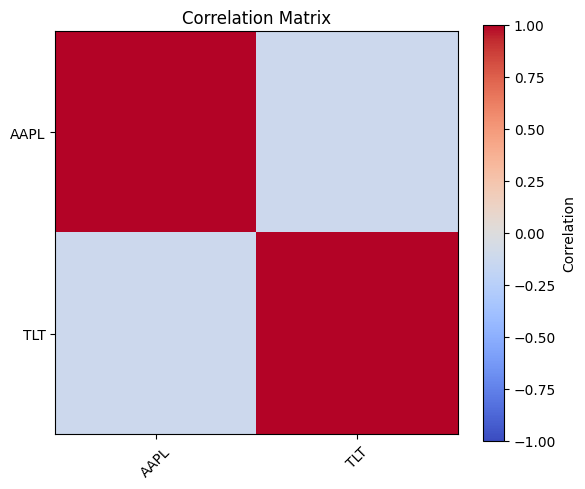

In [7]:
corr_matrix = log_ret_df.corr()
print(corr_matrix)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
im = plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, label="Correlation")

plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.index)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### Questions

1. _Which pairs are highly positively correlated? Any negative pairs?_

No pairs are positively correlated. Just negative (weak) correlation between AAPL and TLT.

2. _Which asset might be a good diversifier in your small universe?_

Since the portfolio volatility at its minimum yields a negative return, adding and asset similar to AAPL would be a good diversifier. Volatility would increase, but returns would be higher.


# Portfolio Variance with Correlation

## Portfolio Variance (Two Assets)

For two assets $A$ and $B$:

$$\sigma_p^2 = w^2 \sigma_A^2 + (1-w)^2 \sigma_B^2 + 2w(1-w)\sigma_A \sigma_B \rho_{AB}$$

## Portfolio Variance (Many Assets)

For many assets, we use the vector form:

$$\sigma_p^2 = w^{\top} \Sigma w$$

*   $w$: Weights vector
*   $\Sigma$: Covariance matrix

We will implement this general formula using the covariance matrix.

## Exercise 3
Compute volatility of portfolio with AAPL and TLT.

In [10]:
cov_matrix = log_ret_df.cov()

def portfolio_volatility(weights, cov_matrix):
    """
    weights: 1D numpy array of shape (n_assets,)
    cov_matrix: pandas DataFrame or numpy array (n_assets x n_assets)
    returns annualized volatility
    """
    w = np.array(weights)
    cov = np.array(cov_matrix)
    var_daily = w.T @ cov @ w
    return np.sqrt(var_daily) * np.sqrt(252)

# Example: equal weights
n = len(log_ret_df.columns)
w_equal = np.ones(n) / n
vol_equal = portfolio_volatility(w_equal, cov_matrix)
print("Equal-weight portfolio annualized vol:", vol_equal)

Equal-weight portfolio annualized vol: 0.1834423572972483


### Questions

1. _Is equal-weight portfolio vol lower than some individual assets’ vol?_

While keeping equal weights, the portfolio vol has decreased overall. However, the assets in the universe are not that correlated. 

2. _What does that say about diversification in your universe?_

Diversification in my universe is not that effective, due to the assets not being correlated. 

# Random Multi-Asset Portfolios

## N-Asset Portfolios

Instead of just two assets, we can consider **all N assets** simultaneously.

You can sample random weight vectors (where weights sum to 1) and compute each portfolio’s risk and return. This generates a "cloud" of possible portfolios, visualizing the feasible region in risk-return space.

## Exercise 4
Compute risk-return cloud of randomly-weighted portfolios.

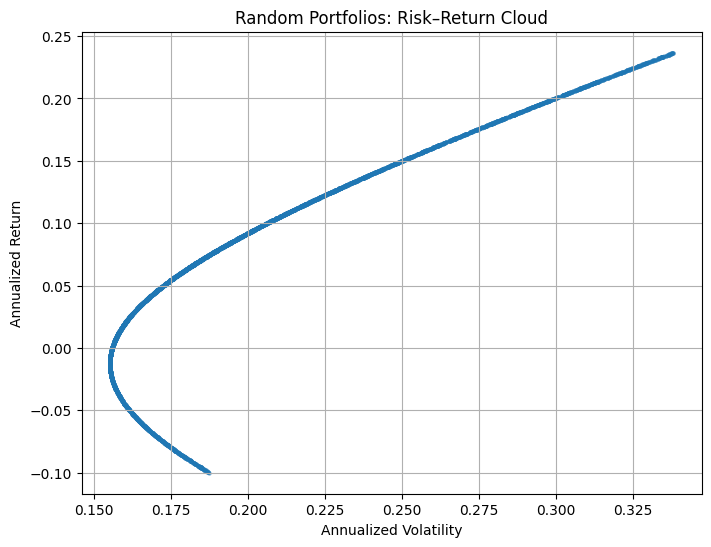

In [13]:
assets = log_ret_df.columns
n_assets = len(assets)

mean_daily_returns = log_ret_df.mean()
mean_annual_returns = mean_daily_returns * 252

def random_weights(n):
    w = np.random.rand(n)
    return w / w.sum()

n_portfolios = 5000
port_returns = []
port_vols = []

for _ in range(n_portfolios):
    w = random_weights(n_assets)
    ret = np.dot(w, mean_annual_returns)
    vol = portfolio_volatility(w, cov_matrix)
    port_returns.append(ret)
    port_vols.append(vol)

plt.figure(figsize=(8, 6))
plt.scatter(port_vols, port_returns, s=5, alpha=0.5)
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Random Portfolios: Risk–Return Cloud")
plt.grid(True)
plt.show()

### Questions

1. _Do you see a “frontier” shape where you can’t get higher return for the same risk?_

Yes, I can see a parabolic shape, meaning that there is a limit to the returns that can be achieved for a given level of risk.

2. _Where do your individual assets lie relative to this cloud (you can overlay them)?_

The individual assets lie below the cloud, meaning that they have lower returns for a given level of risk.

# Approximate Efficient Frontier

## Efficient Frontier

The **Efficient Frontier** is the set of portfolios that offers the **maximum expected return** for a given level of risk (or, equivalently, the **minimum risk** for a given level of return).

While the full Markowitz solution uses quadratic optimization to find this exact curve, we will approximate it here by generating many random portfolios and highlighting the "best" ones (the upper-left boundary of the cloud).

## Exercise 5
Get efficient frontier for 100 random assets portfolio

In [44]:
tickers = ["AAPL","MSFT","GOOGL","AMZN","META","TSLA","NVDA","BRK-B","JPM","V",
"JNJ","WMT","PG","XOM","CVX","UNH","HD","BAC","KO","PFE",
"PEP","DIS","CSCO","ABT","CMCSA","NKE","MCD","ORCL","TMO","COST",
"ABBV","ACN","AVGO","TXN","QCOM","LIN","UPS","PM","BMY","LLY",
"AMD","HON","IBM","BA","CAT","RTX","AMGN","SPGI","GS","BLK",
"AXP","COP","SBUX","INTU","ADP","LMT","PLD","DE","ISRG","GE",
"SYK","NOW","SCHW","DUK","NEE","SO","TGT","MMC","ZTS","APD",
"ETN","FDX","NSC","CSX","ADSK","BDX","AON","AEP","EXC","ECL",
"MRK","GILD","MRNA","BNTX","NEM","FCX","RIO","BHP","VALE","GLD",
"SLV","TLT","IEF","SHY","LQD","HYG","SPY","QQQ","IWM","EFA"]

start_date = "2018-01-01"
end_date = "2024-12-31"

# Download prices
prices_df = pd.DataFrame()
for t in tickers:
    data_t = yf.download(t, start=start_date, end=end_date, progress=False, auto_adjust=False)
    prices_df[t] = data_t["Close"]

In [45]:
# Compute log returns
log_ret_df = np.log(prices_df / prices_df.shift(1)).dropna()

# Covariance matrix of daily log returns
cov_matrix = log_ret_df.cov()

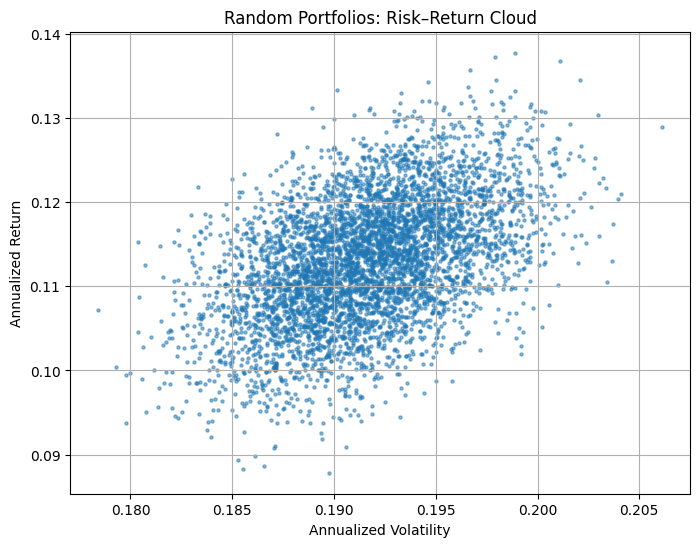

In [46]:
# Risk-Return Cloud
assets = log_ret_df.columns
n_assets = len(assets)

mean_daily_returns = log_ret_df.mean()
mean_annual_returns = mean_daily_returns * 252

def random_weights(n):
    w = np.random.rand(n)
    return w / w.sum()

n_portfolios = 5000
port_returns = []
port_vols = []
port_weights = []

for _ in range(n_portfolios):
    w = random_weights(n_assets)
    ret = np.dot(w, mean_annual_returns)
    vol = portfolio_volatility(w, cov_matrix)
    port_weights.append(w)
    port_returns.append(ret)
    port_vols.append(vol)

plt.figure(figsize=(8, 6))
plt.scatter(port_vols, port_returns, s=5, alpha=0.5)
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Random Portfolios: Risk–Return Cloud")
plt.grid(True)
plt.show()

In [47]:
# Add Sharpe ratio assuming risk-free rate is 0
rf = 0.0
port_sharpes = [(r - rf) / v for r, v in zip(port_returns, port_vols)]

In [48]:
# Find portfolios with max Sharpe ratio and min volatility
idx_max_sharpe = np.argmax(port_sharpes)
idx_min_vol = np.argmin(port_vols)

print("Max Sharpe:", port_sharpes[idx_max_sharpe],
      "Return:", port_returns[idx_max_sharpe],
      "Vol:", port_vols[idx_max_sharpe])

print("Min Vol:", port_vols[idx_min_vol],
      "Return:", port_returns[idx_min_vol])

Max Sharpe: 0.7013407512521872 Return: 0.13334656135077522 Vol: 0.19013091869065887
Min Vol: 0.1784212595676902 Return: 0.10720225589283884


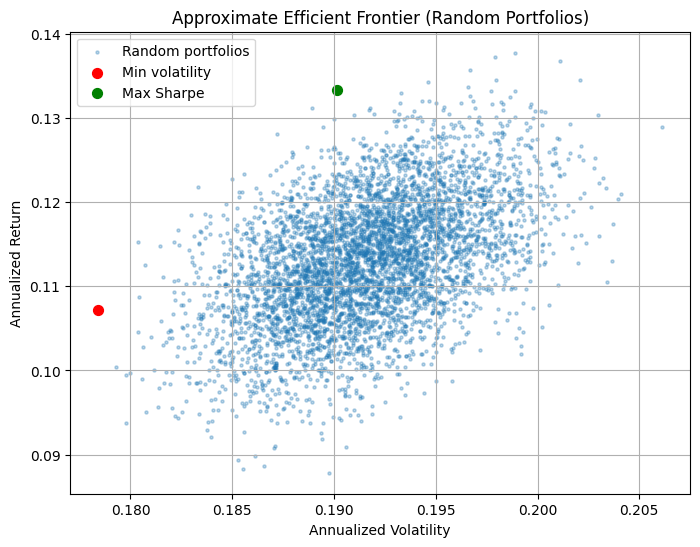

In [49]:
# Plot cloud + highlight frontier points
plt.figure(figsize=(8, 6))
plt.scatter(port_vols, port_returns, s=5, alpha=0.3, label="Random portfolios")

plt.scatter(port_vols[idx_min_vol], port_returns[idx_min_vol],
            color="red", s=50, label="Min volatility")
plt.scatter(port_vols[idx_max_sharpe], port_returns[idx_max_sharpe],
            color="green", s=50, label="Max Sharpe")

plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Approximate Efficient Frontier (Random Portfolios)")
plt.legend()
plt.grid(True)
plt.show()


In [50]:
# Print weights for min-vol and max-sharpe portfolios
w_min_vol = port_weights[idx_min_vol]
w_max_sharpe = port_weights[idx_max_sharpe]

print("Min-vol weights:")
for asset, weight in zip(assets, w_min_vol):
    print(asset, f"{weight:.3f}")

print("\nMax-Sharpe weights:")
for asset, weight in zip(assets, w_max_sharpe):
    print(asset, f"{weight:.3f}")

Min-vol weights:
AAPL 0.010
MSFT 0.015
GOOGL 0.018
AMZN 0.003
META 0.011
TSLA 0.011
NVDA 0.000
BRK-B 0.018
JPM 0.000
V 0.006
JNJ 0.019
WMT 0.016
PG 0.017
XOM 0.017
CVX 0.006
UNH 0.001
HD 0.001
BAC 0.012
KO 0.016
PFE 0.016
PEP 0.018
DIS 0.003
CSCO 0.012
ABT 0.019
CMCSA 0.010
NKE 0.001
MCD 0.005
ORCL 0.011
TMO 0.014
COST 0.007
ABBV 0.018
ACN 0.004
AVGO 0.003
TXN 0.015
QCOM 0.015
LIN 0.019
UPS 0.010
PM 0.011
BMY 0.001
LLY 0.012
AMD 0.009
HON 0.013
IBM 0.010
BA 0.001
CAT 0.004
RTX 0.011
AMGN 0.007
SPGI 0.014
GS 0.003
BLK 0.004
AXP 0.014
COP 0.017
SBUX 0.005
INTU 0.011
ADP 0.012
LMT 0.014
PLD 0.015
DE 0.012
ISRG 0.010
GE 0.014
SYK 0.001
NOW 0.007
SCHW 0.001
DUK 0.001
NEE 0.006
SO 0.004
TGT 0.008
MMC 0.010
ZTS 0.001
APD 0.015
ETN 0.013
FDX 0.002
NSC 0.018
CSX 0.000
ADSK 0.010
BDX 0.012
AON 0.011
AEP 0.015
EXC 0.006
ECL 0.003
MRK 0.015
GILD 0.009
MRNA 0.018
BNTX 0.015
NEM 0.014
FCX 0.001
RIO 0.005
BHP 0.013
VALE 0.012
GLD 0.012
SLV 0.019
TLT 0.013
IEF 0.017
SHY 0.016
LQD 0.006
HYG 0.018
SPY 0

### Questions

1. _How different are min-vol and max-Sharpe portfolios?_

They are different. Min-vol is risk-based, while max-Sharpe is both risk and return-based.

2. _Do they look intuitive (e.g., more bonds for min-vol)?_

Yes, min-vol is more bonds, while max-Sharpe is more equities.